/var/folders/ty/d6vmlsnn34l60px2tgvgj2b80000gn/T/ipykernel_72734/348026941.py:190: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)
/var/folders/ty/d6vmlsnn34l60px2tgvgj2b80000gn/T/ipykernel_72734/348026941.py:190: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)


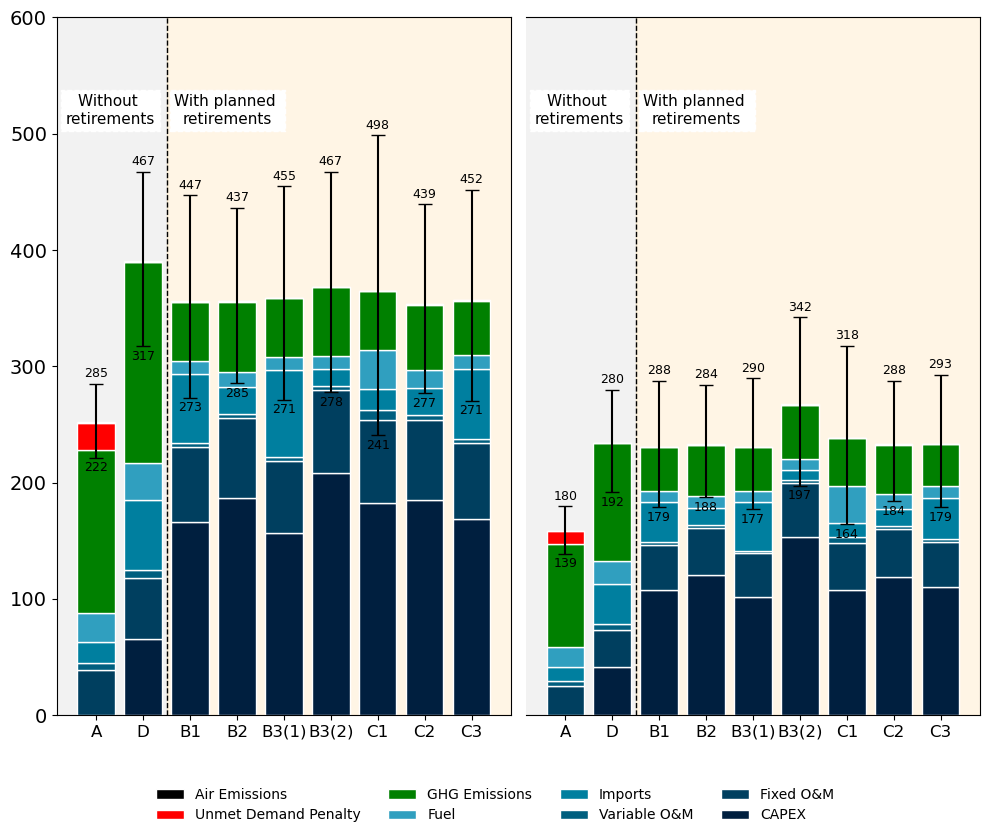

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load CSV for each dataset ---
csv_path_dr3 = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final/All_Costs_dr3.csv"
combined_ranges_dr3 = pd.read_csv(csv_path_dr3)

csv_path_dr7 = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final/All_Costs_dr7.csv"
combined_ranges_dr7 = pd.read_csv(csv_path_dr7)

def format_cost(x):
    """
    Helper function to format numbers (floats) with commas and no decimals.
    """
    return f"{x:,.0f}"

# --- Define stacking order and colors ---
stacking_order = [
    'CAPEX', 'Fixed O&M', 'Variable O&M', 'Imports', 
    'Fuel', 'GHG Emissions', 'Unmet Demand Penalty', 'Air Emissions'
]

custom_colors = {
    'Air Emissions': 'black',
    'Unmet Demand Penalty': 'red',
    'GHG Emissions': 'green',
    'Fuel': '#309fbf',
    'Imports': '#007f9f',
    'Variable O&M': '#005f7f',
    'Fixed O&M': '#003f5f',
    'CAPEX': '#001f3f'
}
colors = [custom_colors[c] for c in stacking_order]

def plot_dataset(data, ax, title=None, show_rectangles=True):
    """
    Plots stacked bars + error bars for a single dataset on a given Axes object.
    """
    # 1) Aggregate costs by Pathway & Statistic
    total_costs = (
        data.groupby(['Pathway', 'Statistic'], as_index=False)
            .agg({'Cost_bUSD': 'sum'})
            .rename(columns={'Cost_bUSD': 'Total_Cost_bUSD'})
    )
    mean_costs = total_costs[total_costs['Statistic'] == 'mean']
    min_costs  = total_costs[total_costs['Statistic'] == 'min']
    max_costs  = total_costs[total_costs['Statistic'] == 'max']

    # 2) Pivot data (only the 'mean' rows) for stacked bar
    stacked_data = (
        data[data['Statistic'] == 'mean']
        .pivot(index='Pathway', columns='Cost_Type', values='Cost_bUSD')
        .fillna(0)
    )
    # Reorder columns in the stacking order
    stacked_data = stacked_data[stacking_order]

    # Optionally reorder rows so certain pathways appear first
    if "D" in stacked_data.index:
        stacked_data = stacked_data.loc[["D"] + [x for x in stacked_data.index if x != "D"]]
    if "A" in stacked_data.index:
        stacked_data = stacked_data.loc[["A"] + [x for x in stacked_data.index if x != "A"]]

    # 3) Plot stacked bars
    for i, col in enumerate(stacked_data.columns):
        bottom_vals = stacked_data.iloc[:, :i].sum(axis=1) if i > 0 else 0
        ax.bar(
            stacked_data.index,
            stacked_data[col],
            bottom=bottom_vals,
            label=col,
            color=colors[i],
            edgecolor="white"
        )

    # 4) Add vertical error bars + text for min / max
    offset = 3
    for pathway in stacked_data.index:
        ymin = min_costs.loc[min_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]
        ymax = max_costs.loc[max_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]
        mean_val = mean_costs.loc[mean_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]

        # Plot error bars
        ax.errorbar(
            x=pathway,
            y=mean_val,
            yerr=[[mean_val - ymin], [ymax - mean_val]],
            fmt='none',
            ecolor='black',
            capsize=5,
            zorder=5
        )
        # Label max value (above the top)
        ax.text(
            x=pathway,
            y=ymax + offset,
            s=format_cost(ymax),
            ha='center',
            va='bottom',
            fontsize=9
        )
        # Label min value (below the bottom)
        ax.text(
            x=pathway,
            y=ymin - offset,
            s=format_cost(ymin),
            ha='center',
            va='top',
            fontsize=9
        )

    # 5) Optionally add rectangles & text
    if show_rectangles:
        # Add dashed divider line
        ax.axvline(x=1.5, color="black", linewidth=1, linestyle="--")
        ax.set_ylim(0, 600)

        # We draw two large translucent rectangles
        rect_width = 3
        rect_height = 600
        rect_x = -0.5
        rect_y = 0

        # 1) Gray rectangle for "Without retirements"
        ax.add_patch(
            plt.Rectangle(
                (rect_x - 1, rect_y),
                rect_width,
                rect_height,
                color="gray",
                alpha=0.1,
                zorder=-1,
                edgecolor=None
            )
        )
        # 2) Orange rectangle for "With planned retirements"
        ax.add_patch(
            plt.Rectangle(
                (rect_x + 2, rect_y),
                rect_width + 5,
                rect_height,
                color="orange",
                alpha=0.1,
                zorder=-1,
                edgecolor=None
            )
        )
        # Annotations for the rectangles
        ax.text(
            x=rect_x + rect_width - 2.2,
            y=rect_y + rect_height - 80,
            s="Without \nretirements",
            fontsize=11,
            ha='center',
            va='center',
            bbox=dict(
                boxstyle='square',
                edgecolor='white',
                linestyle='--',
                facecolor='white'
            )
        )
        ax.text(
            x=rect_x + 3.3,
            y=rect_y + rect_height - 80,
            s="With planned \nretirements",
            fontsize=11,
            ha='center',
            va='center',
            bbox=dict(
                boxstyle='square',
                edgecolor='white',
                linestyle='--',
                facecolor='white'
            )
        )

    # 6) Title and style
    if title:
        ax.set_title(title, fontsize=14, pad=15)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # --- Rename x-axis tick labels for B1 and B1-A ---
    mapping = {"B3": "B3(1)", "B3-A": "B3(2)"}
    new_labels = [mapping.get(item, item) for item in stacked_data.index]
    ax.set_xticklabels(new_labels, fontsize=12)

# -------------------------------------------------------------------------
# Create subplots with a shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

# Plot DR3 on the left
plot_dataset(combined_ranges_dr3, axes[0], show_rectangles=True)

# Plot DR7 on the right
plot_dataset(combined_ranges_dr7, axes[1], show_rectangles=True)

# Remove y-axis ticks & spine from right subplot to achieve a "single y-axis" look
axes[1].tick_params(axis='y', which='both', left=False, labelleft=False)
axes[1].spines['left'].set_visible(False)

# Tighten layout / reduce the gap between subplots
plt.subplots_adjust(wspace=0)

# --- Create a single legend for the figure ---
handles, labels = axes[0].get_legend_handles_labels()
# Reverse so the legend order matches the stack order top-to-bottom
fig.legend(
    handles[::-1],
    labels[::-1],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),  # place at the bottom center
    ncol=4,                       # number of columns in the legend
    frameon=False,
    framealpha=0.9,
    fancybox=True
)

# Adjust layout so the legend at bottom is not cut off
plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.savefig('Total_Costs_Comparison.svg', dpi=300, bbox_inches='tight')
plt.show()


In [38]:
import pandas as pd

def process_costs_df(df: pd.DataFrame) -> pd.DataFrame:
    # Clean up the 'Statistic' and 'Pathway' columns.
    df['Statistic'] = df['Statistic'].astype(str).str.strip().str.lower()
    df['Pathway'] = df['Pathway'].astype(str).str.strip()
    
    # Pivot the data so that for each Pathway and Cost_Type,
    # the three statistics (min, mean, max) become separate columns.
    pivoted = df.pivot_table(
        index=["Pathway", "Cost_Type"],
        columns="Statistic",
        values="Cost_bUSD"
    ).reset_index()
    
    # Create the formatted string "mean [min-max]" (with 2 decimals).
    def format_cost(row):
        try:
            min_val = float(row['min'])
            mean_val = float(row['mean'])
            max_val = float(row['max'])
            return f"{mean_val:.2f} [{min_val:.2f}-{max_val:.2f}]"
        except (ValueError, TypeError):
            return "n/a"
    
    pivoted["formatted"] = pivoted.apply(format_cost, axis=1)
    
    # Pivot wider so that each cost category becomes a separate column.
    final = pivoted.pivot(index="Pathway", columns="Cost_Type", values="formatted").reset_index()
    return final

# Assuming your data is stored in the variables combined_ranges_dr3 and combined_ranges_dr7:
df_dr3_processed = process_costs_df(combined_ranges_dr3)
df_dr7_processed = process_costs_df(combined_ranges_dr7)

# For display, convert the DataFrames to markdown tables.
dr3_md = df_dr3_processed.to_markdown(index=False)
dr7_md = df_dr7_processed.to_markdown(index=False)


In [39]:
df_dr7_processed

Cost_Type,Pathway,Air Emissions,CAPEX,Fixed O&M,Fuel,GHG Emissions,Imports,Unmet Demand Penalty,Variable O&M
0,A,0.52 [0.52-0.53],0.00 [0.00-0.00],25.32 [22.56-27.83],16.72 [7.55-25.89],88.72 [88.20-89.29],12.12 [5.48-20.13],11.26 [10.81-11.81],4.12 [3.91-4.30]
1,B1,0.21 [0.21-0.22],107.77 [85.66-133.36],38.55 [33.22-43.99],9.20 [4.54-13.87],37.55 [36.62-38.86],34.93 [16.63-54.67],0.15 [0.14-0.18],2.21 [2.03-2.37]
2,B2,0.23 [0.23-0.24],120.21 [95.07-149.34],40.90 [35.34-46.62],10.22 [4.64-15.81],43.97 [43.10-45.19],14.73 [6.63-24.22],0.34 [0.30-0.39],2.40 [2.22-2.56]
3,B3,0.21 [0.21-0.22],101.68 [81.02-125.57],37.46 [32.24-42.77],9.25 [4.55-13.95],37.79 [36.85-39.10],42.10 [20.27-65.42],0.13 [0.12-0.16],2.22 [2.04-2.38]
4,B3-A,0.21 [0.21-0.22],153.37 [111.69-198.26],46.48 [35.89-57.16],9.25 [4.55-13.95],46.60 [38.84-54.72],8.97 [3.83-15.41],0.13 [0.12-0.16],2.22 [2.04-2.38]
5,C1,0.23 [0.23-0.23],107.34 [55.50-160.57],41.02 [33.52-50.80],31.51 [24.41-38.67],41.33 [40.60-42.23],12.14 [5.52-19.73],0.24 [0.22-0.27],4.84 [4.34-5.26]
6,C2,0.23 [0.23-0.23],119.12 [91.01-150.83],41.10 [35.14-47.51],12.80 [7.21-18.39],42.24 [41.36-43.49],14.76 [6.63-24.22],0.21 [0.19-0.24],2.69 [2.47-2.88]
7,C3,0.20 [0.20-0.21],110.14 [85.54-137.98],39.23 [33.57-45.21],10.72 [6.20-15.25],35.47 [34.60-36.76],34.98 [16.69-54.67],0.09 [0.08-0.11],2.38 [2.17-2.56]
8,D,0.54 [0.54-0.55],41.23 [34.59-48.95],32.46 [28.37-36.51],19.83 [7.04-32.62],100.84 [99.94-101.68],34.95 [16.69-54.67],0.06 [0.06-0.07],4.53 [4.32-4.73]
